## Description

The aim of this notebook is to preprocess all data from csv files once and for all.
The final_data.pkl will be formatted that way:
* 'carpol':
    * df object with following keys: `date, pressure, humidity, so2_ref, h2s_ref, h2s_0 -> h2s_14 (15pts des 15 dernières minutes), captor_id, t_grad`
    

    


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
df_ref = pd.read_csv('data/RefInstrument_15minDataSet.csv', delimiter=';')
df_ref = df_ref.set_index('date').T  
df_pressure = pd.read_csv('data/Patm_15minDataSet.csv', delimiter=',')
df_pressure = df_pressure.set_index('date').T  
df_grad = pd.read_csv('data/GradientTemp_15minDataSet.csv', delimiter=';')
df_grad = df_grad.set_index('date').T

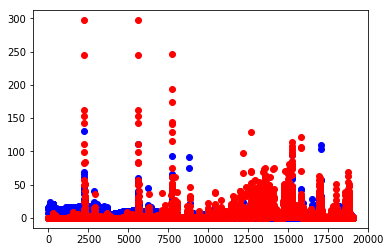

,date,humidity,temperature,pressure,t_grad,so2_ref,h2s_ref,h2s,captor_id
0,2016-05-23 08:15:00,42.0,24.0,1017,NaN,0.0,0.0,7.6,1303
1,2016-05-23 08:30:00,42.0,24.0,1017,NaN,0.0,0.0,14.1,1303
2,2016-05-23 08:45:00,42.0,24.0,1017,NaN,0.0,0.0,14.9,1303
3,2016-05-23 09:00:00,42.0,24.0,1017,NaN,0.0,0.0,15.0,1303
4,2016-05-23 09:15:00,42.0,24.0,1017,NaN,0.0,0.0,14.9,1303


In [3]:
captors_list_filename = (('data/carpol_1303/1303_15minDataSet.csv', '1303'), ('data/carpol_1304/1304_15minDataSet.csv', '1304'))
out_df = pd.DataFrame(columns=['date','humidity', 'temperature', 'pressure', 't_grad', 'so2_ref', 'h2s_ref','h2s','captor_id'])

i = 0

for filename in captors_list_filename:
    df = pd.read_csv(filename[0])
    #print(df.head())
    for row in df.iterrows():
        entry = row[1]
        #0: date, 1: h2s, 2: temp, 3: humidity, 4: npoints
        try:
            date = entry['date']
            ref = df_ref[date]
            h2s_ref = ref[0]
            so2_ref = ref[1]
            t_grad = df_grad[date][0]
            pressure = df_pressure[date][0]
            out_df.loc[i] = [date, entry[3], entry[2], pressure, t_grad, so2_ref, h2s_ref, entry[1], filename[1]]
        except:
            continue
        i += 1
        
tmp_df = out_df[['h2s', 'pressure', 'temperature', 'humidity', 'so2_ref', 'h2s_ref', 't_grad']].apply(pd.to_numeric, errors="coerce")
out_df[['h2s', 'pressure', 'temperature', 'humidity', 'so2_ref', 'h2s_ref', 't_grad']] = tmp_df
plt.plot(out_df['h2s'], 'ob')
plt.plot(out_df['so2_ref'], 'ro')
plt.show()
out_df.to_pickle('data/pickles/carpols_15min.pkl')
out_df.head()

In [4]:
tmp_df = out_df[['pressure', 'temperature', 'humidity', 't_grad']]

normalized_df = (tmp_df - tmp_df.mean()) / tmp_df.std()
out_df[['pressure', 'temperature', 'humidity', 't_grad']] = normalized_df
out_df.to_pickle('data/pickles/carpols_15min_normalized.pkl')
out_df.tail()

,date,humidity,temperature,pressure,t_grad,so2_ref,h2s_ref,h2s,captor_id
19034,2016-11-06 14:30:00,-0.356914,-1.775820,-1.954996,-0.189469,0.4,0.3,0.0,1304
19035,2016-11-06 14:45:00,-0.223696,-1.775820,-1.954996,-0.102774,0.4,0.3,0.0,1304
19036,2016-11-06 15:00:00,-0.157087,-1.949547,-1.954996,-0.102774,0.4,0.4,0.1,1304
19037,2016-11-06 15:15:00,-0.023869,-1.949547,-1.954996,-0.276163,0.4,0.6,0.3,1304
19038,2016-11-06 15:30:00,0.109350,-1.949547,-1.954996,-0.102774,0.4,0.7,0.0,1304


In [6]:
df_carpol_1303 = pd.read_csv('data/carpol_1303/1303_1minDataSet.csv')
df_carpol_1304 = pd.read_csv('data/carpol_1304/1304_1minDataSet.csv')
df_ref = pd.read_csv('data/RefInstrument_15minDataSet.csv', delimiter=';')

def align_df(df1, df2):
    if df1.iloc[0, 0] > df2.iloc[0, 0]:
        return align_df(df2, df1)
    while df1.iloc[0, 0] < df2.iloc[0, 0]:
        df1 = df1.iloc[1:]
    while df2.iloc[0, 0] < df1.iloc[0, 0]:
        df2 = df2.iloc[1:]
    return df1, df2

df_ref_1303, df_carpol_1303 = align_df(df_carpol_1303, df_ref)
df_ref_1304, df_carpol_1304 = align_df(df_carpol_1304, df_ref)

def create_1min_data_set(df_carpol, df_ref, captor):
    if df_carpol.iloc[0, 0] != df_ref.iloc[0, 0]:
        df_carpol, df_ref = align_df(df_carpol, df_ref)
    df = pd.read_csv(os.path.join('data', 'Patm_15minDataSet.csv'))
    pressures = df.set_index('date').T
    i = 0
    out_df = pd.DataFrame(columns=['date','pressure', 'temperature', 'humidity', 't_grad', 'so2_ref', 'h2s', 'h2s_ref','captor_id'])
    df_ref = df_ref.iloc[1:]
    while len(df_carpol) > 0 and len(df_ref) > 0:
        date, h2s_ref, so2_ref = df_ref.iloc[0, 0], df_ref.iloc[0, 1], df_ref.iloc[0, 2]

        temperature, humidity = df_carpol.iloc[0, 2], df_carpol.iloc[0, 3]
        h2s, temperature, humidity = [], [], []
        df_ref = df_ref.iloc[1:]
        while df_carpol.iloc[0, 0] < date:
            h2s.append(df_carpol.iloc[0, 1])
            if df_carpol.iloc[0, 2]:
                temperature.append(df_carpol.iloc[0, 2])
            if df_carpol.iloc[0, 3]:
                humidity.append(df_carpol.iloc[0, 3])
            df_carpol = df_carpol.iloc[1:]
            if len(df_carpol) == 0:
                break
        if len(h2s) != 15:
            continue
        h2s = np.array(h2s)
        if date not in pressures:
            pressure = None

        try:
            out_df.loc[i] = [date, df_pressure[date][0], np.mean(temperature), np.mean(humidity), df_grad[date][0], \
                         so2_ref, h2s, h2s_ref, captor]
            i += 1
        except:
            continue
    print('OK: {}'.format(captor))
    return out_df

out_df_1303 = create_1min_data_set(df_carpol_1303, df_ref_1303, '1303')
out_df_1304 = create_1min_data_set(df_carpol_1304, df_ref_1304, '1304')

out_df = out_df_1303.append(out_df_1304)
out_df.to_pickle('data/pickles/carpols_1min.pkl')
out_df.head()

OK: 1303
OK: 1304


,date,pressure,temperature,humidity,t_grad,so2_ref,h2s,h2s_ref,captor_id
0,2016-05-23 08:30:00,1017,24.0,42.0,NaN,0.0,"[14, 13, 14, 13, 14, 13, 14, 13, 14, 14, 16, 1...",0.0,1303
1,2016-05-23 08:45:00,1017,24.0,42.0,NaN,0.0,"[13, 14, 16, 16, 17, 16, 14, 16, 15, 16, 14, 1...",0.0,1303
2,2016-05-23 09:00:00,1017,24.0,42.0,NaN,0.0,"[17, 13, 14, 13, 15, 15, 15, 16, 15, 14, 16, 1...",0.0,1303
3,2016-05-23 09:15:00,1017,24.0,42.0,NaN,0.0,"[13, 13, 15, 15, 15, 15, 15, 16, 16, 15, 16, 1...",0.0,1303
4,2016-05-23 09:30:00,1017,24.0,42.0,NaN,0.0,"[15, 16, 15, 14, 16, 15, 14, 13, 14, 16, 13, 1...",0.0,1303
